<a href="https://colab.research.google.com/github/nickwan/speed_dating/blob/master/speed_dating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speed dating LULW 

There's a lot of features to play with so I have no idea what I'm really trying to do here. But the last time this happened, we invented advanced bull riding analytics. so...

In [44]:
!pip install shap

     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394118 sha256=a825c08a24e0c725c23472fae6dcba13c0f65fcaee94dc62a274d4199e081b35
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [45]:
from tqdm.notebook import tqdm
import warnings
import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns  
from wordcloud import WordCloud
import shap

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from scipy.stats import pearsonr, spearmanr
shap.initjs()

In [2]:
project_dir = 'drive/My Drive/speed-dating-data'
fns = [f"{project_dir}/data/{x}" for x in os.listdir(f"{project_dir}/data") if x.endswith('.csv')]
df = pd.read_csv(fns[0],encoding='latin_1')
df.shape

(8378, 195)

## Variables 

col | desc   
--- | ---  
iid | unique subject number   
pid | partner's unique subject number  

# Different imbalanced data approaches
There are four ways I show below: 
1. No treatment for imbalanced data 
2. Upsample the minority target weight (currently, ~4:1 for no match:match; weight each match row by 4)  
3. Downsample the majority target weight 
4. Equivalent target proportions in each fold  


In [3]:
target = 'match'
feats = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']

In [4]:
model_data = df.loc[~df['wave'].isin(range(6,10)),['iid','pid','match']].drop_duplicates()
stats = df.loc[:, ['iid']+feats].drop_duplicates().reset_index(drop=True)
model_data = model_data.merge(stats).merge(stats.add_suffix('_p').rename(columns={'iid_p':'pid'})).dropna()
model_data.shape

(6578, 15)

In [5]:
model_data['match'].mean()

0.16509577379142595

In [6]:
model_feats = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1',
       'attr1_1_p', 'sinc1_1_p', 'intel1_1_p', 'fun1_1_p',
       'amb1_1_p', 'shar1_1_p']

target = 'match'       

In [7]:
df_pred = pd.DataFrame()

kf = KFold(50)
for train_idx, test_idx in kf.split(model_data): 
  train_data = model_data.iloc[train_idx] 
  test_data = model_data.iloc[test_idx] 
  model = LogisticRegression(penalty='none')
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data)
df_pred.shape  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

(6578, 16)

loss: 0.4468 (0.448) 
acc: 0.8349 (0.8349)


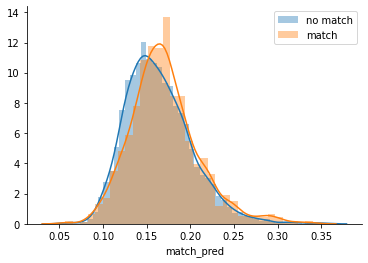

In [8]:
naive_loss = log_loss(df_pred[target], np.repeat([df_pred[target].mean()],df_pred[target].shape[0]))
naive_acc = accuracy_score(df_pred[target], np.round(np.repeat([df_pred[target].mean()],df_pred[target].shape[0]),0))

loss = log_loss(df_pred[target], df_pred[f"{target}_pred"])
acc = accuracy_score(df_pred[target], df_pred[f"{target}_pred"].round(0))

print(f"""loss: {np.round(loss, 4)} ({np.round(naive_loss, 4)}) \nacc: {np.round(acc, 4)} ({np.round(naive_acc, 4)})""")

sns.distplot(df_pred.loc[df_pred['match']==0,f"{target}_pred"], label='no match')
sns.distplot(df_pred.loc[df_pred['match']==1,f"{target}_pred"], label='match')
plt.legend()
sns.despine()
plt.show()

In [9]:
warnings.filterwarnings("ignore")
df_pred = pd.DataFrame()

kf = KFold(50)
for train_idx, test_idx in kf.split(model_data): 
  train_data = model_data.iloc[train_idx] 
  for _ in range(4):
    train_data = train_data.append(train_data.loc[train_data['match']==1])

  test_data = model_data.iloc[test_idx] 
  model = LogisticRegression(penalty='none')
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data)
df_pred.shape  

(6578, 16)

loss: 1.2209 (0.448) 
acc: 0.1651 (0.8349)


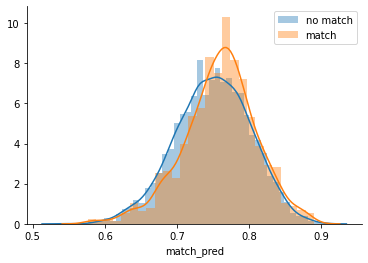

In [10]:
naive_loss = log_loss(df_pred[target], np.repeat([df_pred[target].mean()],df_pred[target].shape[0]))
naive_acc = accuracy_score(df_pred[target], np.round(np.repeat([df_pred[target].mean()],df_pred[target].shape[0]),0))

loss = log_loss(df_pred[target], df_pred[f"{target}_pred"])
acc = accuracy_score(df_pred[target], df_pred[f"{target}_pred"].round(0))

print(f"""loss: {np.round(loss, 4)} ({np.round(naive_loss, 4)}) \nacc: {np.round(acc, 4)} ({np.round(naive_acc, 4)})""")

sns.distplot(df_pred.loc[df_pred['match']==0,f"{target}_pred"], label='no match')
sns.distplot(df_pred.loc[df_pred['match']==1,f"{target}_pred"], label='match')
plt.legend()
sns.despine()
plt.show()

In [11]:
warnings.filterwarnings("ignore")
df_pred = pd.DataFrame()

kf = KFold(50)
for train_idx, test_idx in kf.split(model_data): 
  train_data = model_data.iloc[train_idx] 
  _train_data = train_data.loc[train_data['match']==0].sample(train_data.loc[train_data['match']==1].shape[0])
  train_data = train_data.loc[train_data['match']==1].append(_train_data)

  test_data = model_data.iloc[test_idx] 
  model = LogisticRegression(penalty='none')
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data)
df_pred.shape  

(6578, 16)

loss: 0.6928 (0.448) 
acc: 0.5448 (0.8349)


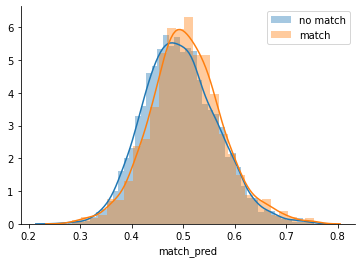

In [12]:
naive_loss = log_loss(df_pred[target], np.repeat([df_pred[target].mean()],df_pred[target].shape[0]))
naive_acc = accuracy_score(df_pred[target], np.round(np.repeat([df_pred[target].mean()],df_pred[target].shape[0]),0))

loss = log_loss(df_pred[target], df_pred[f"{target}_pred"])
acc = accuracy_score(df_pred[target], df_pred[f"{target}_pred"].round(0))

print(f"""loss: {np.round(loss, 4)} ({np.round(naive_loss, 4)}) \nacc: {np.round(acc, 4)} ({np.round(naive_acc, 4)})""")

sns.distplot(df_pred.loc[df_pred['match']==0,f"{target}_pred"], label='no match')
sns.distplot(df_pred.loc[df_pred['match']==1,f"{target}_pred"], label='match')
plt.legend()
sns.despine()
plt.show()

In [14]:
matched_samples = 22 
not_matched_samples = 110
x = np.repeat(np.arange(50),matched_samples)[:model_data.loc[model_data['match']==1].shape[0]]
np.random.shuffle(x)
model_data.loc[model_data['match']==1,'block'] = x

x = np.repeat(np.arange(50),not_matched_samples)[:model_data.loc[model_data['match']==0].shape[0]]
np.random.shuffle(x)
model_data.loc[model_data['match']==0,'block'] = x

In [15]:
warnings.filterwarnings("ignore")
df_pred = pd.DataFrame()
for block_num in range(50): 
  train_data = model_data.loc[model_data['block']!=block_num] 
  test_data = model_data.loc[model_data['block']==block_num] 
  model = LogisticRegression(penalty='none')
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data)
df_pred.shape  

(6578, 17)

loss: 0.4447 (0.448) 
acc: 0.8349 (0.8349)


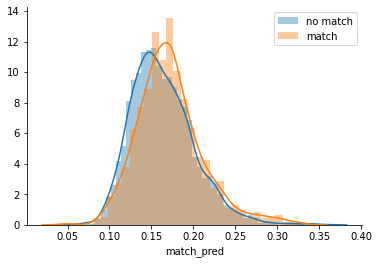

In [16]:
naive_loss = log_loss(df_pred[target], np.repeat([df_pred[target].mean()],df_pred[target].shape[0]))
naive_acc = accuracy_score(df_pred[target], np.round(np.repeat([df_pred[target].mean()],df_pred[target].shape[0]),0))

loss = log_loss(df_pred[target], df_pred[f"{target}_pred"])
acc = accuracy_score(df_pred[target], df_pred[f"{target}_pred"].round(0))

print(f"""loss: {np.round(loss, 4)} ({np.round(naive_loss, 4)}) \nacc: {np.round(acc, 4)} ({np.round(naive_acc, 4)})""")

sns.distplot(df_pred.loc[df_pred['match']==0,f"{target}_pred"], label='no match')
sns.distplot(df_pred.loc[df_pred['match']==1,f"{target}_pred"], label='match')
plt.legend()
sns.despine()
plt.show()

# Add more features 
We'll use the ratings of the partners from the target individual as features. So like, if I was rating "you", I would rate you on the 6 different features of attraction (attractiveness, sincerity, intelligence, fun, ambitious, and shared interests) and you would also rate me. 

However, some folks did not rate people on all of these features. So we'll predict the ratings for the missing values using the other attraction features plus the "like" scale (how much did you like the person). 

In [26]:
model_data = df.loc[:,['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like']].copy()
model_data = model_data.dropna(how='all')
model_data.shape

(8192, 7)

Validation of the features seem to be pretty good. Generally, $RMSE = 1.4$ and $R^2 = 0.42$, which is pretty good for a linear model with zero regularization!  

In [133]:
target = 'like'
model_feats = [x for x in model_data.columns.values if x != target]
target_data = model_data.loc[model_data[target].isnull()].copy()
_model_data = model_data.loc[model_data[target].notnull()].copy().fillna(-1)

df_pred = pd.DataFrame()
kf = KFold(10, shuffle=True)
for train_idx, test_idx in kf.split(_model_data):
  train_data = _model_data.iloc[train_idx]
  test_data = _model_data.iloc[test_idx]

  model = LinearRegression()
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.Series(model.predict(test_data.loc[:,model_feats]), index=test_data.index)

  df_pred = df_pred.append(test_data)

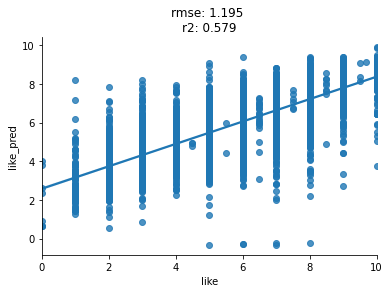

In [134]:
rmse = mean_squared_error(df_pred[target], df_pred[f"{target}_pred"])**0.5
r2 = pearsonr(df_pred[target], df_pred[f"{target}_pred"])[0]**2

sns.regplot(target,f'{target}_pred',data=df_pred)
plt.title(f"""rmse: {round(rmse, 3)} \nr2: {round(r2, 3)}""")
sns.despine()
plt.show()

In [135]:
shap_data = test_data.loc[:,model_feats]
explainer = shap.LinearExplainer(model, train_data.loc[:,model_feats]) 
shap_values = explainer.shap_values(shap_data)

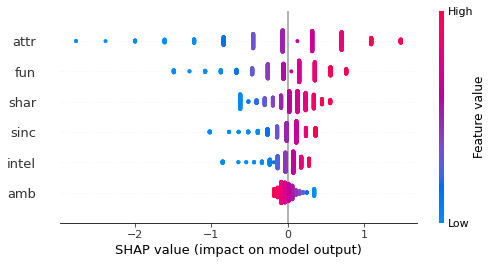

In [136]:
shap.summary_plot(shap_values, shap_data)

In [137]:
shap.initjs()
ind = np.random.choice(range(test_data.shape[0]))
print(f"""actual {target}: {test_data.loc[:,f"{target}"].values[ind]}""")
shap.force_plot(
    explainer.expected_value, 
    shap_values[ind,:], 
    test_data.loc[:,model_feats].values[ind,:], 
    feature_names=model_feats
)


actual like: 2.0


**do the damn thing**

In [158]:
for target in model_data.columns.values:
  model_feats = [x for x in model_data.columns.values if x != target]
  target_data = model_data.loc[model_data[target].isnull()].copy().fillna(-1)
  _model_data = model_data.loc[model_data[target].notnull()].copy().fillna(-1)
  model = LinearRegression()
  model.fit(_model_data.loc[:,model_feats], _model_data.loc[:,target])
  model_data[target] = model_data[target].fillna(pd.Series(model.predict(target_data.loc[:,model_feats]), index=target_data.index))

# replace that shit in the master df
df.loc[:,model_data.columns.values] = model_data

In [204]:
target = 'match'
feats = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']

model_data = df.loc[~df['wave'].isin(range(6,10)),['iid','pid','match']].drop_duplicates()
stats = df.loc[:, ['iid']+feats].drop_duplicates().reset_index(drop=True)
model_data = model_data.merge(stats).merge(stats.add_suffix('_p').rename(columns={'iid_p':'pid'})).dropna()

_x = df.loc[:,['iid','pid','attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like']]
_y = (df
      .loc[:,['iid','pid','attr', 
              'sinc', 'intel', 'fun', 
              'amb', 'shar', 'like']]
      .rename(columns={'iid':'pid', 'pid':'iid'}))

_x =_x.merge(_y, on=['iid','pid'], suffixes=('','_p'))
model_data = model_data.merge(_x).dropna()
model_feats = [x for x in model_data.columns.values if x not in ['iid', 'pid', target]] 
model_data.shape

(6370, 29)

## Using no target balancing for training

In [205]:
df_pred = pd.DataFrame()

kf = KFold(50)
for train_idx, test_idx in kf.split(model_data): 
  train_data = model_data.iloc[train_idx] 
  test_data = model_data.iloc[test_idx] 
  model = LogisticRegression(penalty='none')
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data)
df_pred.shape  

(6370, 30)

loss: 0.3441 (0.4567) 
acc: 0.848 (0.8295)


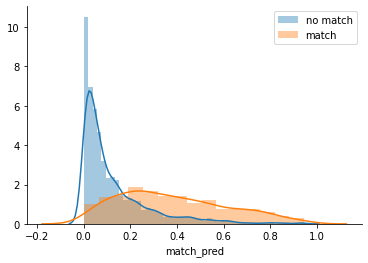

In [206]:
naive_loss = log_loss(df_pred[target], np.repeat([df_pred[target].mean()],df_pred[target].shape[0]))
naive_acc = accuracy_score(df_pred[target], np.round(np.repeat([df_pred[target].mean()],df_pred[target].shape[0]),0))

loss = log_loss(df_pred[target], df_pred[f"{target}_pred"])
acc = accuracy_score(df_pred[target], df_pred[f"{target}_pred"].round(0))

print(f"""loss: {np.round(loss, 4)} ({np.round(naive_loss, 4)}) \nacc: {np.round(acc, 4)} ({np.round(naive_acc, 4)})""")

sns.distplot(df_pred.loc[df_pred['match']==0,f"{target}_pred"], label='no match')
sns.distplot(df_pred.loc[df_pred['match']==1,f"{target}_pred"], label='match')
plt.legend()
sns.despine()
plt.show()

## Use downsampling 

In [210]:
warnings.filterwarnings("ignore")
df_pred = pd.DataFrame()

kf = KFold(50)
for train_idx, test_idx in kf.split(model_data): 
  train_data = model_data.iloc[train_idx] 
  _train_data = train_data.loc[train_data['match']==0].sample(train_data.loc[train_data['match']==1].shape[0])
  train_data = train_data.loc[train_data['match']==1].append(_train_data)

  test_data = model_data.iloc[test_idx] 
  model = LogisticRegression(penalty='none')
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data)
df_pred.shape  

(6370, 31)

loss: 0.5058 (0.4567) 
acc: 0.757 (0.8295)


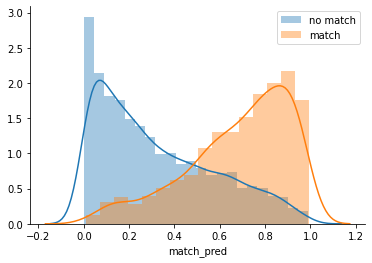

In [211]:
naive_loss = log_loss(df_pred[target], np.repeat([df_pred[target].mean()],df_pred[target].shape[0]))
naive_acc = accuracy_score(df_pred[target], np.round(np.repeat([df_pred[target].mean()],df_pred[target].shape[0]),0))

loss = log_loss(df_pred[target], df_pred[f"{target}_pred"])
acc = accuracy_score(df_pred[target], df_pred[f"{target}_pred"].round(0))

print(f"""loss: {np.round(loss, 4)} ({np.round(naive_loss, 4)}) \nacc: {np.round(acc, 4)} ({np.round(naive_acc, 4)})""")

sns.distplot(df_pred.loc[df_pred['match']==0,f"{target}_pred"], label='no match')
sns.distplot(df_pred.loc[df_pred['match']==1,f"{target}_pred"], label='match')
plt.legend()
sns.despine()
plt.show()

## Using equivalent proportions of targets in each fold

In [212]:
matched_samples = 22 
not_matched_samples = 110
x = np.repeat(np.arange(50),matched_samples)[:model_data.loc[model_data['match']==1].shape[0]]
np.random.shuffle(x)
model_data.loc[model_data['match']==1,'block'] = x

x = np.repeat(np.arange(50),not_matched_samples)[:model_data.loc[model_data['match']==0].shape[0]]
np.random.shuffle(x)
model_data.loc[model_data['match']==0,'block'] = x

In [213]:
warnings.filterwarnings("ignore")
df_pred = pd.DataFrame()
for block_num in range(50): 
  train_data = model_data.loc[model_data['block']!=block_num] 
  test_data = model_data.loc[model_data['block']==block_num] 
  model = LogisticRegression(penalty='none')
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data)
df_pred.shape  

(6370, 31)

loss: 0.3408 (0.4567) 
acc: 0.8493 (0.8295)


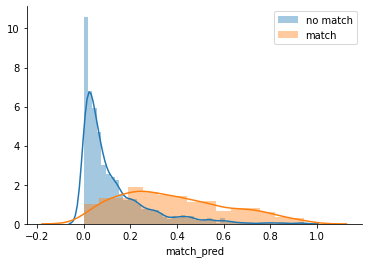

In [214]:
naive_loss = log_loss(df_pred[target], np.repeat([df_pred[target].mean()],df_pred[target].shape[0]))
naive_acc = accuracy_score(df_pred[target], np.round(np.repeat([df_pred[target].mean()],df_pred[target].shape[0]),0))

loss = log_loss(df_pred[target], df_pred[f"{target}_pred"])
acc = accuracy_score(df_pred[target], df_pred[f"{target}_pred"].round(0))

print(f"""loss: {np.round(loss, 4)} ({np.round(naive_loss, 4)}) \nacc: {np.round(acc, 4)} ({np.round(naive_acc, 4)})""")

sns.distplot(df_pred.loc[df_pred['match']==0,f"{target}_pred"], label='no match')
sns.distplot(df_pred.loc[df_pred['match']==1,f"{target}_pred"], label='match')
plt.legend()
sns.despine()
plt.show()

In [223]:
test_data = model_data.loc[:,model_feats+[target]].sample(1500)
train_data = model_data.loc[~model_data.index.isin(test_data.index.values), model_feats+[target]]

In [224]:
shap_data = test_data.loc[:,model_feats]
explainer = shap.LinearExplainer(model, train_data.loc[:,model_feats]) 
shap_values = explainer.shap_values(shap_data)

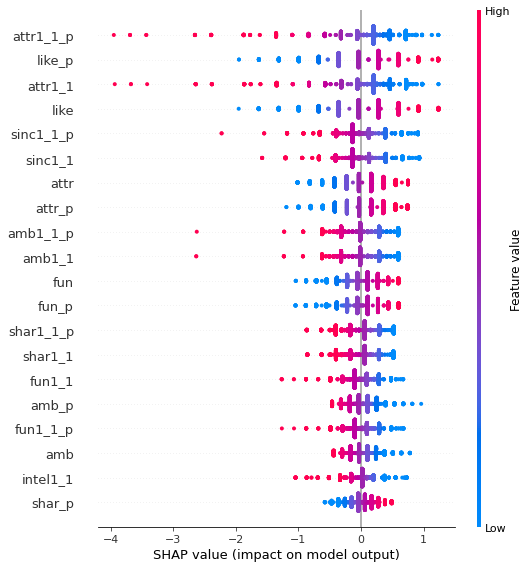

In [225]:
shap.summary_plot(shap_values, shap_data)

In [273]:
shap.initjs()
ind = np.random.choice(range(test_data.shape[0]))
print(f"""actual {target}: {test_data.loc[:,f"{target}"].values[ind]}""")
shap.force_plot(
    explainer.expected_value, 
    shap_values[ind,:], 
    test_data.loc[:,model_feats].values[ind,:], 
    feature_names=model_feats
)


actual match: 1
